In [ ]:
import deepxde as dde
import numpy as np
from scipy import integrate
from deepxde.backend import tf
import matplotlib.pyplot as plt
import seaborn as sns

Considerando o sistema de equações
$$\begin{align}
\frac{1}{A_{t}} \frac{dF_1}{dz} &= - \eta  r \\
\frac{1}{A_{t}} \frac{dF_2}{dz} &= -4 \eta  r \\
\frac{1}{A_{t}} \frac{dF_3}{dz} &= \eta r \\
\frac{1}{A_{t}} \frac{dF_4}{dz} &= 2 \eta  r \\
\end{align}$$, com $A_t = 2, \eta = 1$ e $r = 2$ e as seguintes condições iniciais $$ F_{i,0}(z) = \begin{cases}
    94.74 \, \frac{\text{mol}}{\text{s}} \, \\
    378.9 \, \frac{\text{mol}}{\text{s}} \, \\
    0 \,  \\
    0 \,
\end{cases} \quad 0 < z \leq L$$

In [ ]:
A = 2
n = 1
r = 2

def func(z, f):
    f1, f2, f3, f4 = f
    df1_z = -n * A * r
    df2_z = -4* n * A * r
    df3_z = n * A * r
    df4_z = 2 * n * A * r
    return df1_z, df2_z, df3_z, df4_z


## Gerar dados resolvendo por Runge-Kutta

In [ ]:
def gen_truedata():
    t = np.linspace(0, 3, 1000)

    sol = integrate.solve_ivp(func, (0, 3), [94.74, 378.9, 0, 0], t_eval=t)
    f1, f2, f3, f4 = sol.y
    f1_true = f1.reshape(1000, 1)
    f2_true = f2.reshape(1000, 1)
    f3_true = f3.reshape(1000, 1)
    f4_true = f4.reshape(1000, 1)

    return f1_true, f2_true, f3_true, f4_true,


In [ ]:
def ode_system(z, f):
    f1 = f[:, 0:1]
    f2 = f[:, 1:2]
    f3 = f[:, 2:3]
    f4 = f[:, 4:5]
    df1_z = dde.grad.jacobian(f, z, i = 0)
    df2_z = dde.grad.jacobian(f, z, i = 1)
    df3_z = dde.grad.jacobian(f, z, i = 2)
    df4_z = dde.grad.jacobian(f, z, i = 3)
    return [ df1_z + n * A * r,
    df2_z + 4* n * A * r,
    df3_z - n * A * r,
    df4_z - 2 * n * A * r
    ]

In [ ]:
geom = dde.geometry.TimeDomain(0, 3)
data = dde.data.PDE(geom, ode_system, [], 10000, 4, num_test = 1000)

## Definindo arquitetura

In [ ]:
layer_size = [1] + [64] * 4 + [5]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

## Treinamento

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=500)

Compiling model...
Building feed-forward neural network...
'build' took 0.110184 s

'compile' took 1.067180 s

Training model...

0         [1.42e+01, 2.52e+02, 1.75e+01, 6.27e+01]    [1.42e+01, 2.52e+02, 1.75e+01, 6.27e+01]    []  
500       [4.90e-03, 5.62e-02, 2.71e-03, 7.97e-03]    [4.48e-03, 5.09e-02, 2.69e-03, 7.84e-03]    []  

Best model at step 500:
  train loss: 7.18e-02
  test loss: 6.59e-02
  test metric: []

'train' took 89.683222 s



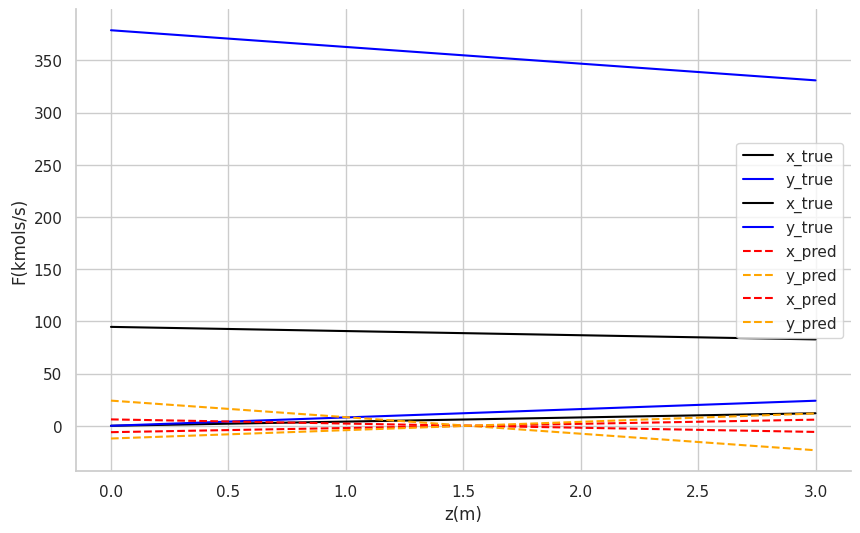

In [ ]:
t = np.linspace(0, 3, 1000)
f1_true, f2_true, f3_true, f4_true = gen_truedata()

sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10, 6))

plt.plot(t, f1_true, color="black", label="x_true")
plt.plot(t, f2_true, color="blue", label="y_true")
plt.plot(t, f3_true, color="black", label="x_true")
plt.plot(t, f4_true, color="blue", label="y_true")

t = t.reshape(1000, 1)
sol_pred = model.predict(t)
f1_pred = sol_pred[:, 0:1]
f2_pred = sol_pred[:, 1:2]
f3_pred = sol_pred[:, 2:3]
f4_pred = sol_pred[:, 3:4]

plt.plot(t, f1_pred, color="red", linestyle="--", label="x_pred")
plt.plot(t, f2_pred, color="orange", linestyle="--", label="y_pred")
plt.plot(t, f3_pred, color="red", linestyle="--", label="x_pred")
plt.plot(t, f4_pred, color="orange", linestyle="--", label="y_pred")

plt.legend()
plt.xlabel("z(m)")
plt.ylabel("F(kmols/s)")
sns.despine()

plt.show()